_Autor:_    __Jesús Casado__ <br> _Revisión:_ __14/05/2020__ <br>


__Descripción__:<br>
Regenerar series para las estaciones del Saja-Besaya:

E055, A707, A708, Q119, P071

__Cosas a corregir__ <br>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid')
plt.style.use("dark_background")

In [2]:
%run funciones_seriesCHC.ipynb

In [3]:
# ruta OneDrive
rutaOneDrive = 'OneDrive - Universidad de Cantabria/'
if os.path.exists('F:/' + rutaOneDrive):
    rutaOneDrive = 'F:/' + rutaOneDrive
elif os.path.exists('C:/Users/jcr693/' + rutaOneDrive):
    rutaOneDrive = 'C:/Users/jcr693/' + rutaOneDrive
else:
    print('No se encontró la ruta a OneDrive.')

In [4]:
rutaSAIH = rutaOneDrive + 'Series/CHC/SAI/originales/'

In [5]:
rutaExport = rutaOneDrive + 'Clases/TFGs/Pablo&Abraham/Data/SAIH/'

In [6]:
estacion = 'P071'
rutaorig = rutaSAIH
freq = '1D'
export_orig = True
rutaexp = rutaExport
verbose = True
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
    # rutas
    rutaSAIH1 = rutaorig + '/Hasta junio de 2015/'
    rutaSAIH2 = rutaorig + '/Desde julio de 2015/'

    signames = {'AIPCINC': 'precipitacion_mm',
                'ACQRIO1': 'caudal_m³/s',
                'AINRIO1': 'nivel_m',
                'AINRL7S': 'nivel_m',
                'AITEMEX': 'temperatura_C',
                #'_PIEZO': 'piezometro_m',
                #'_POZO': 'piezometro_m',
                #'_LIMNI': 'limnimetro_m',
                'AIA3ATS': 'amonio_mg/l',
                'AIMPCTS': 'conductividad_μS/cm',
                'AIMPO2S': 'oxigeno_mg/l',
                'AIMPPHS': 'pH',
                'AIMPTTS': 'temperaturaAgua_C',
                'AITUTUS': 'turbidez_NTU'}
    redondeo = {'precipitacion_mm': 1, 'caudal_m³/s': 2, 'nivel_m': 2, 'temperatura_C': 3,
                'amonio_mg/l': 2, 'conductividad_μS/cm': 0, 'oxigeno_mg/l': 1, 'pH': 1,
                'temperaturaAgua_C': 1, 'turbidez_NTU': 0}# 'piezometro_m': 3, 'limnimetro_m': 3, 
    errormin = {'precipitacion_mm': 0, 'caudal_m³/s': 0, 'nivel_m': 0, 'temperatura_C': -10,
                'amonio_mg/l': 0, 'conductividad_μS/cm': 0, 'oxigeno_mg/l': 0, 'pH': 0,
                'temperaturaAgua_C': -10, 'turbidez_NTU': 0}# 'piezometro_m': 0, 'limnimetro_m': 0, 
    errormax = {'precipitacion_mm': 500, 'caudal_m³/s': 2000, 'nivel_m': 20, 'temperatura_C': 40,
                'amonio_mg/l': 1e4, 'conductividad_μS/cm': 1e6, 'oxigeno_mg/l': 1e3, 'pH': 15,
                'temperaturaAgua_C': 50, 'turbidez_NTU': 1e2}# 'piezometro_m': 1e3, 'limnimetro_m': 1e3,

In [8]:
    # PARTE 1
    # -------
    # encontrar archivos de la estación
    folders = os.listdir(rutaSAIH1)
    for f, folder in enumerate(folders):
        if folder[:4] == str(estacion):
            ruta_stn = rutaSAIH1 + folder + '/'
            files = [file for file in os.listdir(ruta_stn) if file[:4] == folder[:4]]

            # Importar datos cincominutales
            data1 = pd.DataFrame()
            for i, file in enumerate(files):
                # importar serie original
                aux = pd.read_csv(ruta_stn + file, sep=';', encoding='latin-1', decimal=',', low_memory=False, na_values=[-100, 65535, 6523.6, -816])
                aux.dropna(axis=0, how='all', inplace=True)
                aux.Fecha = [datetime.strptime(date, '%d/%m/%Y %H:%M') for date in aux.Fecha]
                aux.set_index('Fecha', drop=True, inplace=True)
                # reordenar 'aux' por señales
                signals = [signal for signal in aux['Nombre señal'].unique() if signal[-7:] in list(signames.keys())]
                aux2 = pd.DataFrame()#columns=cols)
                for signal in signals:
                    temp = aux.loc[aux['Nombre señal'] == signal, 'Valor']
                    cols = list(aux2.columns)
                    aux2 = pd.concat((aux2, temp), axis=1, sort=True)
                    aux2.columns = cols + [str(estacion) + 'X' + signal[-7:]]
                # concatenar a la serie generada
                data1 = pd.concat((data1, aux2), axis=0, sort=True)
            break

In [9]:
    if 'data1' in locals():
        # convertir columnas de señales a variables
        data1.columns = [signames[col[5:]] for col in data1.columns if col[5:] in list(signames.keys())]

        # identificar variable repetidas
        cols = list(data1.columns)
        varCount = {x: cols.count(x) for x in set(cols)}

        # corregir variables repetidas
        for var in varCount:
            if varCount[var] == 1:
                continue
            else:
                # posiciones de la variable en la tabla
                pos = [i for i, col in enumerate(cols) if col == var]
                # unificar serie
                serie = pd.Series(index=data1.index)
                for p in pos:
                    part = data1.iloc[:,p].copy()
                    st, en = part.first_valid_index(), part.last_valid_index()
                    serie.loc[st:en] = part.loc[st:en]
                # eliminar columnas repetidas
                data1.drop(var, axis=1, inplace=True)
                # añadir serie unificada
                data1[var] = serie

In [10]:
data1.head()

NameError: name 'data1' is not defined

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(data1['temperatura_C'])
#plt.xlim('2014-7', '2015-3')
plt.grid(False);

In [11]:
    # PARTE 2
    # -------
    # encontrar carpeta de la estación
    folders = os.listdir(rutaSAIH2)
    for folder in folders:
        if folder[:4] == str(estacion):
            ruta_stn = rutaSAIH2 + folder + '/'
            # encontrar archivos de la estación
            files = os.listdir(ruta_stn)
            # corregir nombre del archivo si fuera necesario
            for i, file in enumerate(files):
                if len(file) > 16:
                    new_file = file[:12] + file[-4:]
                    try:
                        os.rename(ruta_stn + file, ruta_stn + new_file)
                        files[i] = new_file
                    except:
                        continue
            # Importar datos cincominutales
            data2 = pd.DataFrame()
            for file in files:
                aux = pd.read_csv(ruta_stn + file, sep=';', decimal=',', encoding='latin-1', skiprows=1)
                aux['Fecha/Hora'] = [datetime.strptime(date, '%d/%m/%Y %H:%M') for date in aux['Fecha/Hora']]
                aux.set_index('Fecha/Hora', drop=True, inplace=True)
                aux.index.name = 'Fecha'
                #cols = [col for col in aux.columns if col[-7:] in list(signames.keys())]
                cols = [col for col in aux.columns if col[5:] in list(signames.keys())]
                aux = aux.loc[:, cols]
                data2 = pd.concat((data2, aux), axis=0, sort=True)
            del files, folders   
            break

    data2.columns = [signames[col[5:]] for col in data2.columns if col[5:] in list(signames.keys())]

In [12]:
data2.head(2)

,precipitacion_mm,temperatura_C
Fecha,,
2018-08-31 00:00:00,0.0,13.670
2018-08-31 00:05:00,0.0,13.547


In [13]:
var = 'temperatura_C'
plt.figure(figsize=(16, 3.5))
plt.plot(data1[var], lw=.5)
plt.plot(data2[var], lw=.5)
#plt.xlim('2012', '2013')
plt.grid(False);

NameError: name 'data1' is not defined

<Figure size 1152x252 with 0 Axes>

In [14]:
    # UNIR SERIES
    # -----------
    # unir las dos series como serie minutal para evitar errores
    if ('data1' in locals()) and ('data2' in locals()):
        idx = pd.date_range(data1.index[0], data2.index[-1], freq='min')
        cols = list(data1.columns) + list(set(data2.columns) - set(data1.columns))
        data = pd.DataFrame(index=idx, columns=cols)
        data.loc[data2.index,:] = data2
        data.loc[data1.index,:] = data1
    elif ('data1' in locals()) and ('data2' not in locals()):
        idx = pd.date_range(data1.index[0], data1.index[-1], freq='min')
        data = pd.DataFrame(index=idx, columns=data1.columns)
        data.loc[data1.index,:] = data1
    elif ('data2' in locals()) and ('data1' not in locals()): 
        idx = pd.date_range(data2.index[0], data2.index[-1], freq='min')
        data = pd.DataFrame(index=idx, columns=data2.columns)
        data.loc[data2.index,:] = data2.loc[:, data.columns]

In [15]:
    # Agregar datos a la frecuencia de medición: 5 min
    data_5min = data.resample('5min').apply(np.nansum)
    count_5min = data.resample('5min').count()
    data_5min[count_5min == 0] = np.nan
    # corregir nombre de las columnas
    data_5min.index.name = 'Fecha'
    # corregir valores
    for col in data_5min.columns:
        mask = (data_5min[col] < errormin[col]) | (data_5min[col] > errormax[col])
        data_5min.loc[mask, col] = np.nan
    data_5min = data_5min.astype(float).round(redondeo)
    

```Python
    def outlier(x):
        p = int(len(x) / 2)
        pos = np.arange(len(x)) != p
        mean = np.mean(x[pos])
        std = np.std(x[pos])
        return abs(mean - x[p]) / std

    # corregir valores
    for col in data_5min.columns:
        print('{0:>20}'.format(col))
        if col == 'precipitacion_mm':
            continue
        else:
            # comprobar que el dato no contrasta con el resto de datos en una ventana móvil de 1 h
            mask = data_5min[col].rolling(window=13, center=True).apply(outlier, raw=False) > 5
            data_5min.loc[mask, col] = np.nan
```

In [16]:
    # remuestrear datos a la frecuencia deseada
    aux = data_5min.copy()  # copia de la serie obervada corregida
    if freq != None:
        data_ag = aux.resample(freq).sum()
        counts = aux.resample(freq).count()
        data_ag[counts == 0] = np.nan
        for col in data_ag.columns:
            if col in ['caudal_m³/s', 'nivel_m', 'temperatura_C']:
                data_ag[col] /= counts[col]
        data_ag = data_ag.astype(float).round(redondeo)

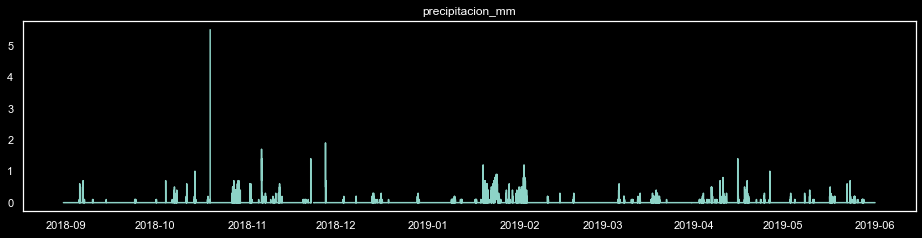

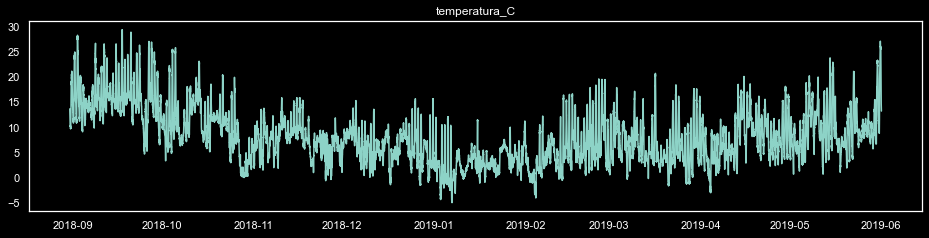

In [17]:
for col in data_5min.columns:
    plt.figure(figsize=(16, 3.5))
    plt.plot(data_5min[col])
    plt.title(col)
    #plt.xlim('2015-5-19', '2015-6')
    plt.grid(False);

In [18]:
    # EXPORTAR
    # --------
    # exportar la serie cincominutal 
    if (export_orig == True) or (freq == None):
        ruta_5min = rutaexp + '5min/'
        if not os.path.exists(ruta_5min):
            os.makedirs(ruta_5min)
        data_5min.to_csv(ruta_5min + str(estacion) + '.csv', sep=',', na_rep='')#,
                         #float_format='%.3f')
    # exportar la serie remuestreada
    if freq != None:
        ruta_ag = rutaexp + freq + '/'
        if not os.path.exists(ruta_ag):
            os.makedirs(ruta_ag)
        data_ag.to_csv(ruta_ag + str(estacion) + '.csv', sep=',', na_rep='')#,
                       #float_format='%.3f')

    if verbose == True:
        print('nº de días de las serie:\t', data_ag.shape[0])
        print('variables:\t', list(data_ag.columns))

nº de días de las serie:	 274
variables:	 ['precipitacion_mm', 'temperatura_C']
